In [1]:
import numpy as np
import os
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from super_gradients.training import models
import glob
from scipy.optimize import linear_sum_assignment, least_squares

/home/yh6917/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2023-05-15 17:43:17] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/yh6917/sg_logs/console.log


2023-05-15 17:43:20.114596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 17:43:20.359736: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-15 17:43:21.119920: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yh6917/.local/lib/python3.10/site-packages/cv2/../../lib64:/home/yh6917/nuws/inst

In [15]:
# read 3 frames of images
img_path1 = 'KITTI_sequence_1/image_l/000000.png'
img_path2 = 'KITTI_sequence_1/image_l/000001.png'
img_path3 = 'KITTI_sequence_1/image_l/000005.png'

img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)
img3 = cv2.imread(img_path3)

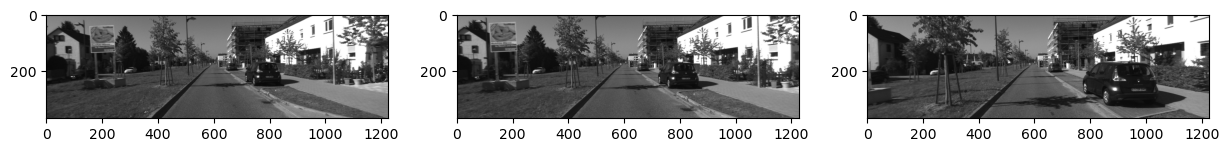

In [16]:
# show images
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(img1)
plt.subplot(132)
plt.imshow(img2)
plt.subplot(133)
plt.imshow(img3)
plt.show()

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.get("yolo_nas_s", pretrained_weights="coco").to(device)

def object_detection(image):
    for item in model.predict(image, conf=0.6)._images_prediction_lst:
        bboxes = item.prediction.bboxes_xyxy
        labels = item.prediction.labels
        return bboxes, labels
    return None, None

[2023-05-15 17:51:51] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


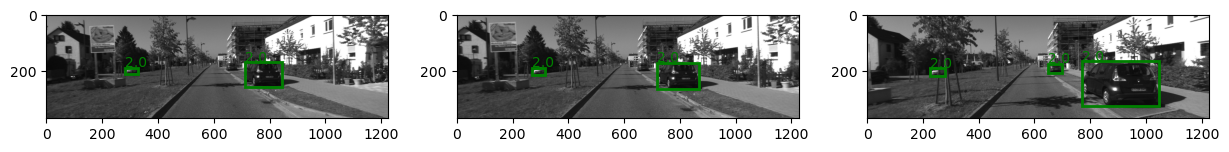

In [18]:
# detect objects in 3 frames
bboxes1, labels1 = object_detection(img1)
bboxes2, labels2 = object_detection(img2)
bboxes3, labels3 = object_detection(img3)

# show detected objects
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(img1)
for bbox, label in zip(bboxes1, labels1):
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), (bbox[2] - bbox[0]), (bbox[3] - bbox[1]), fill=False, edgecolor='g', linewidth=2))
    plt.text(bbox[0], bbox[1] - 3, str(label), color='g')
plt.subplot(132)
plt.imshow(img2)
for bbox, label in zip(bboxes2, labels2):
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), (bbox[2] - bbox[0]), (bbox[3] - bbox[1]), fill=False, edgecolor='g', linewidth=2))
    plt.text(bbox[0], bbox[1] - 3, str(label), color='g')
plt.subplot(133)
plt.imshow(img3)
for bbox, label in zip(bboxes3, labels3):
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), (bbox[2] - bbox[0]), (bbox[3] - bbox[1]), fill=False, edgecolor='g', linewidth=2))
    plt.text(bbox[0], bbox[1] - 3, str(label), color='g')
plt.show()

In [19]:
def compute_iou(box1, box2):
    """
    Computes IoU (Intersection over Union) between two bounding boxes
    IoU is a metric for evaluating simularity between two bounding boxes
    IoU is a value between 0 and 1, where 1 means the two bounding boxes are identical
    """
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    x5, y5, x6, y6 = (max(x1, x3), max(y1, y3), min(x2, x4), min(y2, y4))
    if x5 > x6 or y5 > y6:
        return 0
    else:
        intersection = (x6 - x5) * (y6 - y5)
        union = (x2 - x1) * (y2 - y1) + (x4 - x3) * (y4 - y3) - intersection
        return intersection / union

In [20]:
def assign_objects(bboxes1, bboxes2, labels1, labels2):
    cost_matrix = np.zeros((len(bboxes1), len(bboxes2)))

    for i, bbox1 in enumerate(bboxes1):
        for j, bbox2 in enumerate(bboxes2):
            if labels1[i] == labels2[j]:
                iou = compute_iou(bbox1, bbox2)
                cost_matrix[i, j] = 1 - iou  # Convert IOU to cost by taking 1 - iou

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    matches = []
    for i, j in zip(row_ind, col_ind):
        if cost_matrix[i, j] < (1 - 0.5):
            matches.append((i, j))

    return matches

In [21]:
matches_1_2 = assign_objects(bboxes1, bboxes2, labels1, labels2)
matches_1_2

[(0, 0), (1, 1)]

In [22]:
object_library = {}

In [29]:
def compare_with_existing_objects(object_library, bbox):
    all_iou = []
    all_keys = []
    for key, value in object_library.items():
        iou = compute_iou(value, bbox)
        all_iou.append(iou)
        all_keys.append(key)

    if len(all_iou) > 0:
        max_iou = max(all_iou)
        max_iou_index = all_iou.index(max_iou)
        max_iou_key = all_keys[max_iou_index]

        if max_iou > 0.5:
            return max_iou_key
    return None

In [30]:
def update_object_library(object_library, bbox):
    key = compare_with_existing_objects(object_library, [bbox])
    if key is None:
        key = len(object_library)
        object_library[key] = None
    object_library[key] = bbox
    return object_library

In [ ]:
def find_transformation(object_library, key, new_bbox):
    